AUC:  0.9789226726726727


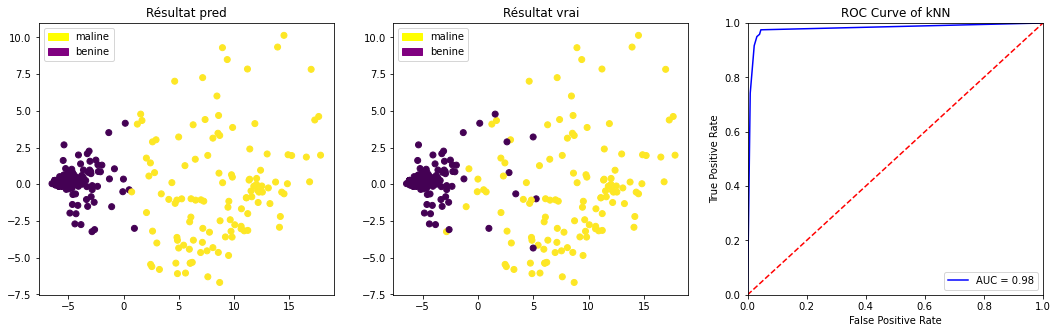

Matrice de confusion :
[[215   7]
 [  6 114]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       222
           1       0.94      0.95      0.95       120

    accuracy                           0.96       342
   macro avg       0.96      0.96      0.96       342
weighted avg       0.96      0.96      0.96       342

Accuracy : 0.9619883040935673


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.patches as mpatches
import numpy as np
import scipy.io as sp
from sklearn.decomposition import PCA

#traitement mat
cancercell=sp.loadmat('breastw.mat')
X = cancercell['X']
y = cancercell['y']
#print(cancercell)
y=np.reshape(y,(683,))
#Séparation des données d'apprentissage et des données tests
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)
#fin traitement mat

#valeurs
k=5
# fin valeurs

#algo knn
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train,y_train)
prediction= model.predict(X_test)
model_PCA = PCA(n_components=2)
data_reduced = model_PCA.fit_transform(X_test)
#fin algo knn

#print(model.predict_proba(X_test))
X_scores = model.predict_proba(X_test)
y_scores = model.predict_proba(X_test)


#graphique
plt.figure(figsize=(18,5))
plt.subplot(1, 3, 1)
plt.scatter(data_reduced[:,0],data_reduced[:,1],c=prediction)
plt.title("Résultat pred")
maline = mpatches.Patch(color='yellow', label='maline')
benine = mpatches.Patch(color='purple', label='benine')
plt.legend(handles=[maline,benine])

plt.subplot(1, 3, 2)
plt.scatter(data_reduced[:,0],data_reduced[:,1],c=y_test)
plt.title("Résultat vrai")
maline = mpatches.Patch(color='yellow', label='maline')
benine = mpatches.Patch(color='purple', label='benine')
plt.legend(handles=[maline,benine])

#  ROC curve
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC: ", roc_auc)

plt.subplot(1, 3, 3)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

#fin graphique

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
result = confusion_matrix(y_test, prediction)
print("Matrice de confusion :")
print(result)
result1 = classification_report(y_test, prediction)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,prediction)
print("Accuracy :",result2)
